In [8]:
import json
import multiprocessing
import signal
from concurrent.futures import ProcessPoolExecutor
from functools import partial
from typing import Dict, List
from datasets import load_dataset

import fire
from pymatgen.core import Structure
from mattext.analysis.xtal2pot import Xtal2Pot

In [9]:
linearpotential = Xtal2Pot(
    geometry_potential="rasp_potential"
)

In [10]:
dataset = load_dataset("n0w0f/MatText", "gvrh-test-filtered")

In [11]:
s =dataset['fold_0']['cif_p1'][2]
structure = Structure.from_str(str(s), "cif")

In [15]:
structure

Structure Summary
Lattice
    abc : 5.33 5.33 6.15
 angles : 115.69 115.69 89.94000000000001
 volume : 138.07382302411696
      A : 4.803143866407869 0.0 -2.3105646492986214
      B : -1.1053092351955849 4.674236033407266 -2.3105646492986214
      C : 0.0 0.0 6.15
    pbc : True True True
PeriodicSite: Cu0 (Cu) (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Cu1 (Cu) (0.3718, 3.506, 0.7644) [0.25, 0.75, 0.5]
PeriodicSite: B2 (B) (1.849, 2.337, -2.311) [0.5, 0.5, 0.0]
PeriodicSite: B3 (B) (3.326, 1.169, 0.7644) [0.75, 0.25, 0.5]
PeriodicSite: Se4 (Se) (3.025, 4.067, -2.39) [0.83, 0.87, 0.25]
PeriodicSite: Se5 (Se) (1.597, 1.776, -0.311) [0.42, 0.38, 0.25]
PeriodicSite: Se6 (Se) (2.838, 0.7946, 2.764) [0.63, 0.17, 0.75]
PeriodicSite: Se7 (Se) (-0.0647, 2.711, 2.995) [0.12, 0.58, 0.75]

In [16]:
linearpotential.get_potential(structure)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0
0.0
-3.0
0.0
0.0
0.0
0.0
0.0
-3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0
-3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0
-3.0
-2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.0
0.0
0.0
0.0
0.0
0.0
-3.0
0.0
0.0
0.0
0.0
0.0
0.0
[0. 1. 1. 1. 0. 1. 1. 1.]
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


(1.5339999999999998, 0.75)

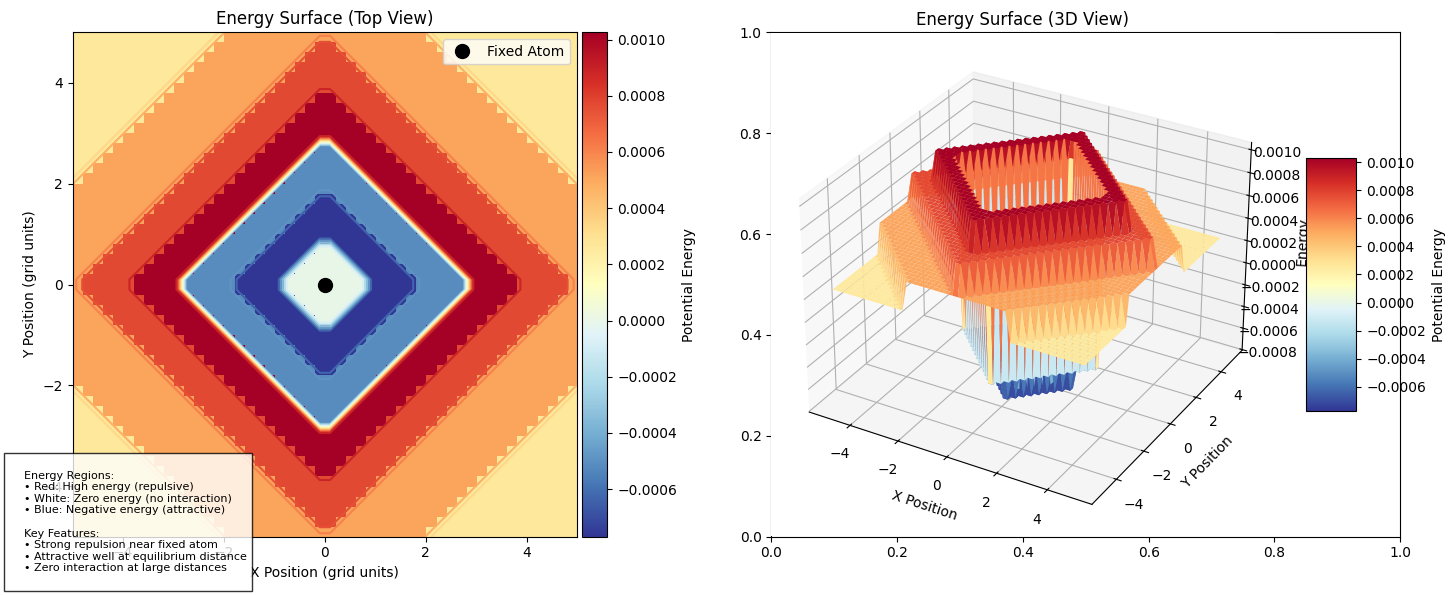

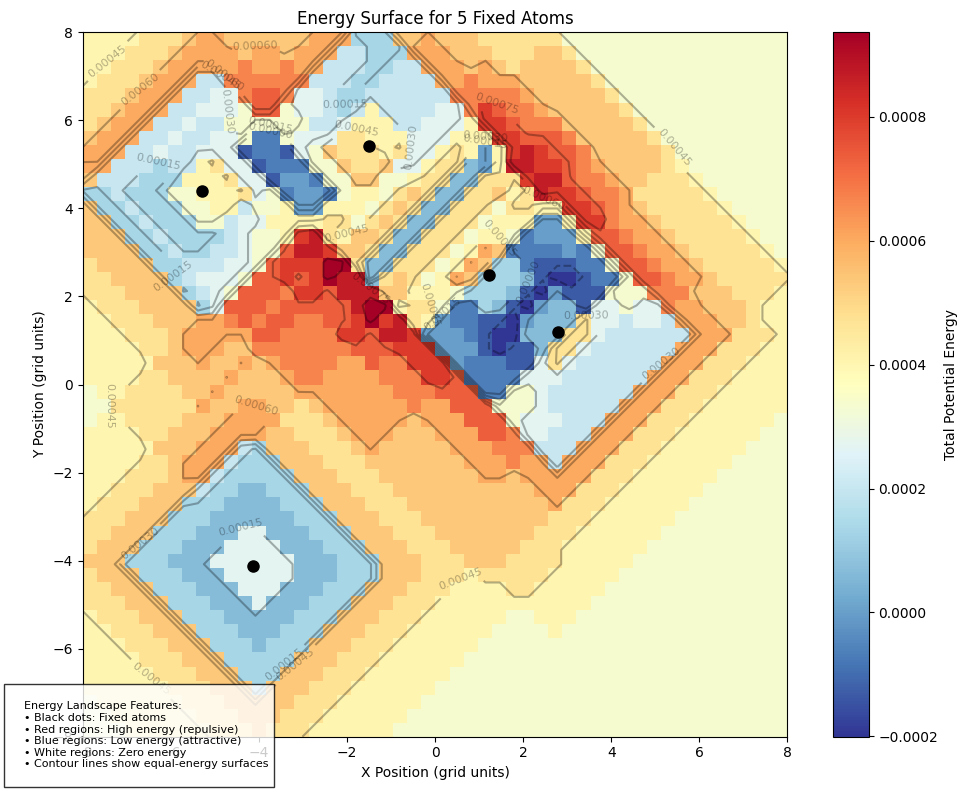

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_2d_energy_surface(grid_size=50, save_path=None):
    """
    Plot 2D energy surface of the RASP potential.
    Shows energy landscape when one atom is fixed at center and another moves in x-y plane.
    
    Args:
        grid_size (int): Number of points along each axis
        save_path (str, optional): If provided, saves the plot to this path
    """
    # Define the potential
    distance_potential = {
            1: 3.0,  # very close - highly repulsive
            2: 2.0,  # repulsive
            3: -4.0,  # attractive (equilibrium)
            4: -3.0,  # weakly attractive
            5: -2.0,  # negligible interaction
            6: -2.0, # no interaction
            7: -1.0,
            8: -1.0,
            9: -1.0,
            10: 0.0,
            11: 0.0,

        }

    
    def get_energy(dx, dy):
        """Calculate energy for given displacements"""
        # Manhattan distance (converted to grid units)
        dist = abs(dx) + abs(dy)
        binned_dist = min(int(dist), 8)
        return distance_potential.get(binned_dist, 0)
    
    # Create coordinate grid
    x = np.linspace(-5, 5, grid_size)
    y = np.linspace(-5, 5, grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Calculate energy at each point
    Z = np.zeros_like(X)
    for i in range(grid_size):
        for j in range(grid_size):
            Z[i,j] = get_energy(X[i,j], Y[i,j])

    total_energy = np.sum(Z)
    Z = Z/total_energy  # normalize to total energy
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Surface plot
    surf = ax1.contour(X, Y, Z, levels=15, cmap='RdYlBu_r')
    im = ax1.imshow(Z, extent=[-5, 5, -5, 5], origin='lower', 
                    cmap='RdYlBu_r', aspect='equal')
    
    # Add center atom marker
    ax1.plot([0], [0], 'ko', markersize=10, label='Fixed Atom')
    
    # Add colorbar
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax, label='Potential Energy')
    
    ax1.set_title('Energy Surface (Top View)')
    ax1.set_xlabel('X Position (grid units)')
    ax1.set_ylabel('Y Position (grid units)')
    ax1.legend()
    
    # 3D surface plot
    ax2 = plt.subplot(122, projection='3d')
    surf = ax2.plot_surface(X, Y, Z, cmap='RdYlBu_r', 
                           linewidth=0, antialiased=True)
    
    ax2.set_title('Energy Surface (3D View)')
    ax2.set_xlabel('X Position')
    ax2.set_ylabel('Y Position')
    ax2.set_zlabel('Energy')
    
    # Add colorbar
    plt.colorbar(surf, ax=ax2, shrink=0.5, aspect=5, label='Potential Energy')
    
    # Add text description
    text = """
    Energy Regions:
    • Red: High energy (repulsive)
    • White: Zero energy (no interaction)
    • Blue: Negative energy (attractive)
    
    Key Features:
    • Strong repulsion near fixed atom
    • Attractive well at equilibrium distance
    • Zero interaction at large distances
    """
    plt.figtext(0.02, 0.02, text, fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig

def plot_multiple_atoms_energy(n_atoms=5, grid_size=50, save_path=None):
    """
    Plot 2D energy surface for multiple fixed atoms.
    
    Args:
        n_atoms (int): Number of fixed atoms to place
        grid_size (int): Number of points along each axis
        save_path (str, optional): If provided, saves the plot to this path
    """
    # Define the potential
    distance_potential = {
            1: 3.0,  # very close - highly repulsive
            2: 2.0,  # repulsive
            3: -4.0,  # attractive (equilibrium)
            4: -3.0,  # weakly attractive
            5: -2.0,  # negligible interaction
            6: -2.0, # no interaction
            7: -1.0,
            8: -1.0,
            9: -1.0,
            10: 0.0,
            11: 0.0,

        }

    
    def get_energy(dx, dy):
        dist = abs(dx) + abs(dy)
        binned_dist = min(int(dist), 8)
        return distance_potential.get(binned_dist, 0)
    
    # Create coordinate grid
    x = np.linspace(-8, 8, grid_size)
    y = np.linspace(-8, 8, grid_size)
    X, Y = np.meshgrid(x, y)
    
    # Generate random positions for fixed atoms
    np.random.seed(42)  # for reproducibility
    fixed_positions = []
    for _ in range(n_atoms):
        pos = (np.random.uniform(-6, 6), np.random.uniform(-6, 6))
        fixed_positions.append(pos)
    
    # Calculate total energy at each point
    Z = np.zeros_like(X)
    for i in range(grid_size):
        for j in range(grid_size):
            # Sum up interactions with all fixed atoms
            for fx, fy in fixed_positions:
                dx = X[i,j] - fx
                dy = Y[i,j] - fy
                Z[i,j] += get_energy(dx, dy)
    total_energy = np.sum(Z)
    Z = Z/total_energy  # normalize to total energy
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot energy surface
    im = ax.imshow(Z, extent=[-8, 8, -8, 8], origin='lower', 
                   cmap='RdYlBu_r', aspect='equal')
    
    # Add contour lines
    contours = ax.contour(X, Y, Z, levels=10, colors='k', alpha=0.3)
    ax.clabel(contours, inline=True, fontsize=8)
    
    # Plot fixed atoms
    for fx, fy in fixed_positions:
        ax.plot(fx, fy, 'ko', markersize=8)
    
    # Add colorbar
    plt.colorbar(im, label='Total Potential Energy')
    
    ax.set_title(f'Energy Surface for {n_atoms} Fixed Atoms')
    ax.set_xlabel('X Position (grid units)')
    ax.set_ylabel('Y Position (grid units)')
    
    # Add description
    text = """
    Energy Landscape Features:
    • Black dots: Fixed atoms
    • Red regions: High energy (repulsive)
    • Blue regions: Low energy (attractive)
    • White regions: Zero energy
    • Contour lines show equal-energy surfaces
    """
    plt.figtext(0.02, 0.02, text, fontsize=8, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig

# Example usage:
fig1 = plot_2d_energy_surface(grid_size=50)
fig2 = plot_multiple_atoms_energy(n_atoms=5, grid_size=50)
plt.show()

In [14]:
import signal
import json
from typing import List, Dict
from datasets import load_dataset  # Assumes datasets library from Hugging Face
from pymatgen.core import Structure  # Assumes pymatgen is installed


class TimeoutException(Exception):
    """Custom exception class for timeouts."""
    pass


def timeout_handler(signum, frame):
    """Custom signal handler for timeouts."""
    raise TimeoutException


# Set up the signal handler for timeouts
signal.signal(signal.SIGALRM, timeout_handler)


def process_entry_test(entry: dict, timeout: int, alphas=None) -> dict:
    """Process an entry for test dataset with a timeout."""
    try:
        signal.alarm(timeout)  # Start the timer
        
        # Get the structure from CIF representation
        structure = Structure.from_str(str(entry["cif_p1"]), "cif")
        
        # Create output dictionary with existing representations
        output = {
            "mbid": entry["mbid"],
            "zmatrix": entry["zmatrix"],
            "atoms_params": entry["atoms_params"],
            "local_env": entry["local_env"],
            "cif_p1": entry["cif_p1"],
            "composition": entry["composition"],
            "crystal_llm_rep": entry["crystal_llm_rep"]
        }
        
        # Calculate energies (dummy values used here for illustration)
        # Replace `linearpotential.get_potential` with actual energy calculation if needed
        composition_energy, geometry_energy = linearpotential.get_potential(structure)
        output["composition_energy"] = composition_energy
        output["geometry_energy"] = geometry_energy
        
        signal.alarm(0)  # Reset the timer
        return output
    except TimeoutException:
        print("Timeout error processing a row")
        return None
    except Exception as e:
        print(f"Error processing a row: {e}")
        print(entry["cif_p1"])
        return None


def process_dataset(
    data_repository: str = 'n0w0f/MatText',
    subsets: List[str] = None,
    output_dir: str = "processed_data",
    timeout: int = 600,
    test_sample_size: int = None,
    alphas: List[float] = None,
):
    """Process datasets from Hugging Face for different subsets."""
    if subsets is None:
        subsets = [
            "gvrh-test-filtered",
            "perovskites-test-filtered",
            "dielectric-test-filtered"
        ]
    
    for subset in subsets:
        print(f"\nProcessing subset: {subset}")
        
        # Load dataset from Hugging Face
        try:
            dataset = load_dataset(data_repository, subset)['fold_0']
            print(f"Loaded dataset with {len(dataset)} entries")
            if test_sample_size:
                dataset = dataset.select(range(min(test_sample_size, len(dataset))))
        except Exception as e:
            print(f"Error loading dataset {subset}: {e}")
            continue

        # Convert dataset to list of dictionaries with all representations
        data = [{
            "mbid": item["mbid"],
            "cif_p1": item["cif_p1"],
            "zmatrix": item["zmatrix"],
            "atoms_params": item.get("atoms_params", {}),
            "local_env": item["local_env"],
            "composition": item["composition"],
            "crystal_llm_rep": item["crystal_text_llm"]
        } for item in dataset]

        processed_entries = []

        for i, entry in enumerate(data, start=1):
            print(f"Processing entry {i} of subset {subset}")
            result = process_entry_test(entry, timeout, alphas)
            if result is not None:
                processed_entries.append(result)

        # Save final results for this subset
        output_file = f"{output_dir}/{subset}_processed.json"
        with open(output_file, "w") as f:
            json.dump(processed_entries, f)

        print(f"Finished processing {subset}!")
        print(f"Results saved to {output_file}")
        print(f"Total processed entries: {len(processed_entries)}")


# Run the dataset processing
process_dataset()



Processing subset: gvrh-test-filtered
Loaded dataset with 1528 entries
Processing entry 1 of subset gvrh-test-filtered
0.0
0.0
0.0
0.0
[0. 0.]
[0. 0.]
Processing entry 2 of subset gvrh-test-filtered
0.0
-3.0
0.0
0.0
0.0
0.0
-2.0
0.0
0.0
0.0
0.0
0.0
-3.0
0.0
0.0
0.0
-2.0
0.0
-2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0
0.0
0.0
-2.0
-3.0
0.0
0.0
-4.0
0.0
0.0
0.0
0.0
0.0
-2.0
-2.0
0.0
0.0
-4.0
-3.0
0.0
0.0
-2.0
-2.0
0.0
0.0
0.0
-2.0
0.0
-1.0
0.0
0.0
-2.0
0.0
0.0
0.0
-2.0
0.0
0.0
0.0
-2.0
0.0
-2.0
-1.0
0.0
-2.0
-2.0
0.0
-2.0
-2.0
0.0
0.0
0.0
0.0
-2.0
-1.0
0.0
0.0
0.0
-2.0
0.0
0.0
-2.0
0.0
0.0
-1.0
0.0
0.0
-2.0
0.0
0.0
-3.0
0.0
-1.0
0.0
0.0
-1.0
0.0
0.0
0.0
-4.0
0.0
0.0
0.0
-4.0
0.0
-2.0
-2.0
0.0
0.0
0.0
-4.0
0.0
0.0
0.0
0.0
-3.0
0.0
-1.0
-1.0
0.0
0.0
-4.0
0.0
0.0
0.0
0.0
-4.0
0.0
-2.0
0.0
0.0
-2.0
-4.0
0.0
0.0
0.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Processing entry 3 of subset gvrh-test-filtered
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [7]:
import numpy as np 
def rasp_geometric_potential(
    x_coords: np.ndarray, y_coords: np.ndarray, z_coords: np.ndarray
) -> float:
    """
    RASP-compatible geometric potential using only attention-like operations.
    Robust version that handles array indexing safely.
    """

    def kqv(
        k: np.ndarray, q: np.ndarray, v: np.ndarray, pred
    ) -> np.ndarray:
        """
        Simulates attention-like mechanism with safe indexing.
        Now passes indices instead of values to pred function.
        """
        s = len(k)
        A = np.zeros((s, s), dtype=bool)

        # Pass indices to pred instead of values
        for i in range(s):
            for j in range(s):
                A[i, j] = pred(j, i)  # passing indices instead of values

        #return np.dot(A, v)
        out = np.dot(A, v)
        norm = np.dot(A, np.ones(len(A)))
        return np.divide(out, norm, out=np.zeros_like(v), where=(norm != 0))

    def get_pair_energy(idx1: int, idx2: int) -> float:
        """
        Compute pairwise energy using array indices instead of direct values.
        """
        distance_potential = {
            1: 3.0,  # very close - highly repulsive
            2: 2.0,  # repulsive
            3: -4.0,  # attractive (equilibrium)
            4: -3.0,  # weakly attractive
            5: -2.0,  # negligible interaction
            6: -2.0, # no interaction
            7: -1.0,
            8: 0.0,
            9: 0.0,
            10: 0.0,
            11: 0.0,

        }

        # Safely compute distances using indices
        dx = abs(x_coords[idx1] - x_coords[idx2])
        dy = abs(y_coords[idx1] - y_coords[idx2])
        dz = abs(z_coords[idx1] - z_coords[idx2])

        dist = dx + dy + dz
        #print(dist)
        pe =  distance_potential.get(min(dist, 8), 0.0)
        print(pe)
        return pe

    # Ensure inputs are numpy arrays and properly shaped
    x_coords = np.asarray(x_coords, dtype=np.int32)
    y_coords = np.asarray(y_coords, dtype=np.int32)
    z_coords = np.asarray(z_coords, dtype=np.int32)

    if len(x_coords) == 0:
        print("I am here")
        return 0.0

    # First attention operation - compute pairwise energies
    # Now passing indices to get_pair_energy through the pred function
    energies = kqv(
        k=np.arange(len(x_coords)),  # use indices instead of coordinates
        q=np.arange(len(x_coords)),
        v=np.ones(len(x_coords), dtype=float),
        pred=lambda idx_k, idx_q: get_pair_energy(idx_k, idx_q) # clip between -10 and 10,
    )



    print(energies)
    if len(energies) == 0:
        return 0.0
    total_energy = kqv(
        k=np.arange(len(x_coords)),
        q=np.ones(len(x_coords)),  # Query all positions
        v=energies,
        pred=lambda k, q: True,  # Include all interactions
    )
    print(total_energy)

    return float(total_energy[0])



def to_int_coords(coords: np.ndarray) -> np.ndarray:
        """Safely convert coordinates to integer representation."""
        return np.clip((coords * 9).astype(np.int32), -127, 127)



In [8]:
index = 2
s =dataset['fold_0']['cif_p1'][index]
structure = Structure.from_str(str(s), "cif")

In [9]:
fractional_coords = structure.frac_coords
x_coords = to_int_coords(fractional_coords[:, 0])
y_coords = to_int_coords(fractional_coords[:, 1])
z_coords = to_int_coords(fractional_coords[:, 2])

e = rasp_geometric_potential(x_coords, y_coords, z_coords)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0
0.0
-3.0
0.0
0.0
0.0
0.0
0.0
-3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0
-3.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.0
-3.0
-2.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-3.0
0.0
0.0
0.0
0.0
0.0
-3.0
0.0
0.0
0.0
0.0
0.0
0.0
[0. 1. 1. 1. 0. 1. 1. 1.]
[0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]


In [10]:
e

0.75